# Requesting Argo BGC data from Ifremer erddap, expert mode

Using the expert mode, you can have access to all fields retrieved from the erddap, including all QC variables and without any data mode filtering.

***
Script prepared by [Guillaume Maze](http://github.com/gmaze) (Mar. 2020)

In [1]:
import sys, os
import numpy as np
import xarray as xr

# Not definitive access to the end-user API:
sys.path.insert(0, os.path.abspath('..'))
from argopy import DataFetcher as ArgoDataFetcher

#
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Usefull colormaps and colorbar makers:
qcmap = mpl.colors.ListedColormap(['#000000', 
                                   '#31FC03', 
                                   '#ADFC03', 
                                   '#FCBA03', 
                                   '#FC1C03',
                                   '#324CA8', 
                                   '#000000', 
                                   '#000000', 
                                   '#B22CC9', 
                                   '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['A','D','R'])

dmode_map = mpl.colors.ListedColormap(['#FCBA03','#31FC03','#FF0000'])
def colorbar_dmode(cmap=dmode_map, **kwargs):
    """Adjust colorbar ticks with discrete colors for DATA MODE"""
    ncolors = 3
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(le.classes_)
    return colorbar

# Create the Argo data loader instance

If we want to retrieve data without post-processing, we need to specify the ``mode`` option to ``expert`` when creating the data loader instance.

In [4]:
argo_loader = ArgoDataFetcher(mode='expert', ds='bgc')
# argo_loader = ArgoDataFetcher(mode='expert', cachedir='tmp')
argo_loader

<datafetcher 'Not initialised'>
Fetchers: 'profile', 'float' or 'region'
User mode: expert

# Example of data fetching for a specific region (Equatorial East-Pacific)

In [3]:
# box = [-120., -85., -10, 10, 0, 1000, '2018-01-01','2018-12-31']
box = [-120., -85., -10, 10, 0, 1000, '2019-01-01','2019-12-31']
argo = argo_loader.region(box).to_xarray()
argo

NameError: name 'argo_loader' is not defined

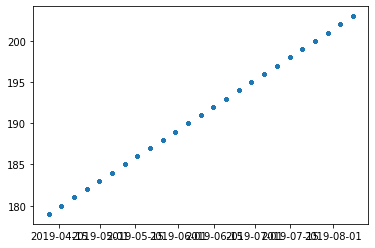

In [26]:
plt.plot(argo['time'], argo['CYCLE_NUMBER'], '.')

## QC figure with unfiltered data

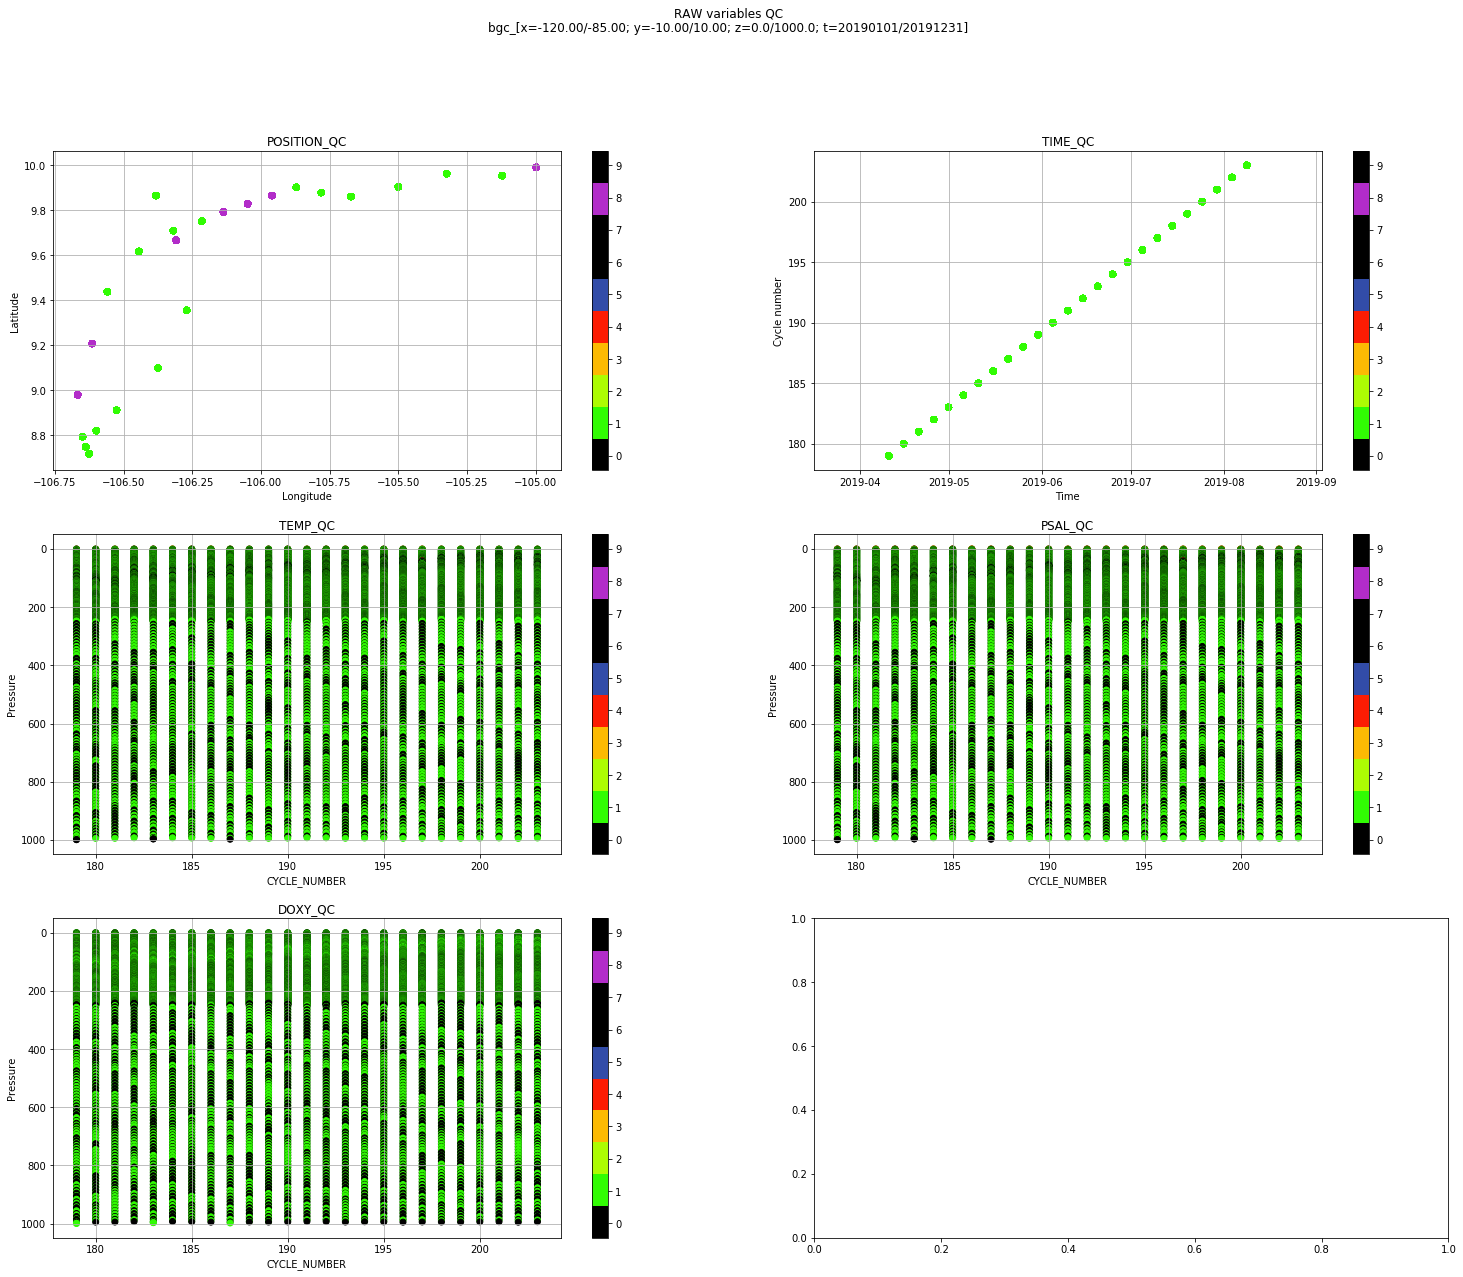

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,20))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['DOXY_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('DOXY_QC')

fig.suptitle("RAW variables QC\n%s" % argo.attrs['Download_constraints']);

# Filter data according to data mode

But this is (nearly) the raw output of the request. It could be useful to simply select the most appropriate variables according to the data mode (Real time, adjusted and delayed mode). 

Note that this is done automatically in ``mode='standard'``.

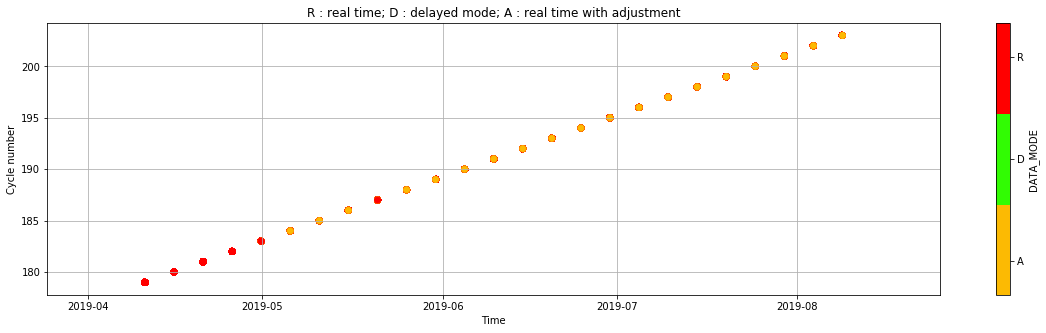

In [20]:
# Inspect data mode
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Cycle number')
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Filter data according to data mode

In [27]:
argo_filtered = argo_loader.region(box).fetcher.filter_data_mode(argo)

## QC figure with appropriate variables

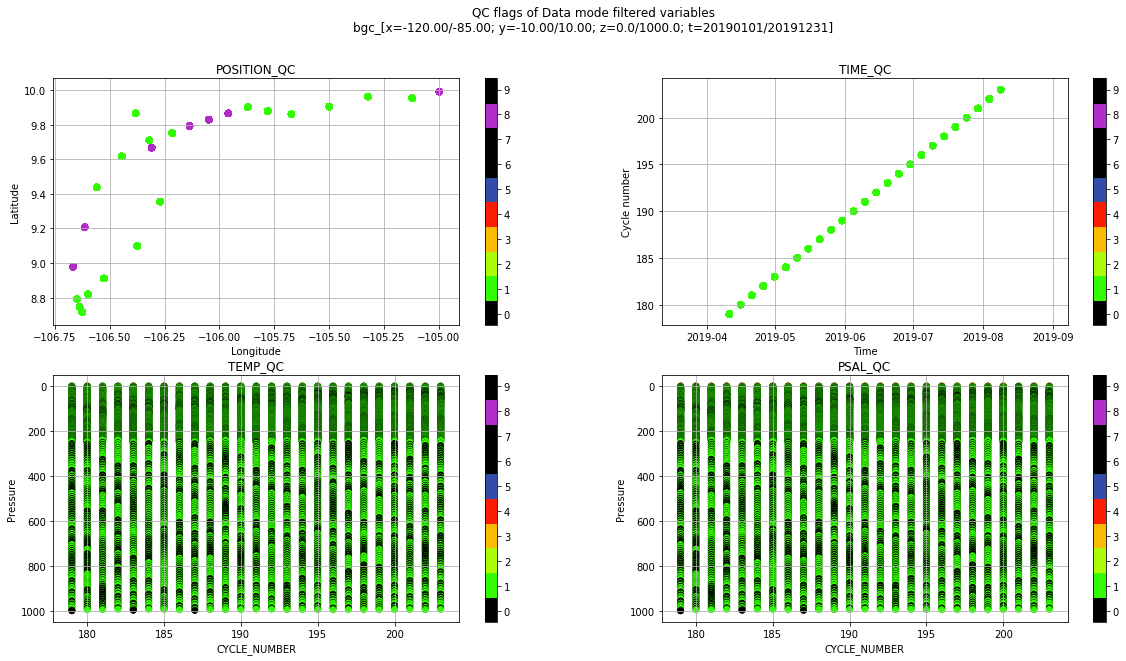

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_filtered['longitude'], argo_filtered['latitude'], c=argo_filtered['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['time'].values, argo_filtered['CYCLE_NUMBER'], c=argo_filtered['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo_filtered['CYCLE_NUMBER'], argo_filtered['PRES'], c=argo_filtered['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("QC flags of Data mode filtered variables\n%s" % argo.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [96]:
import requests
import io
import pandas as pd
from IPython.core.display import display, HTML

def urlopen(url):
    r = requests.get(url)
    data = io.BytesIO(r.content).read()
    
    if r.status_code == 200: # OK
        return data

    # 4XX client error response
    elif r.status_code == 404: # Empty response
        error = ["Error %i " % r.status_code]
        error.append(data.decode("utf-8").replace("Error",""))
        raise requests.HTTPError(error)

    # 5XX server error response    
    elif r.status_code == 500: # 500 Internal Server Error
        if "text/html" in r.headers.get('content-type'):
            display(HTML(data.decode("utf-8")))
        else:
            error = ["Error %i " % r.status_code]
            error.append(data.decode("utf-8"))
            raise requests.HTTPError(error)

In [99]:
float_fetcher = argo_loader.float(3901530)
# float_fetcher = argo_loader.float(6902746)
# float_fetcher = argo_loader.region([-180,180,0,90,0,1000])
# float_fetcher = argo_loader.float(2903005) # Float with a RBRargo sensor

url = float_fetcher.fetcher.get_download_url(response='htmlTable')
print(url)


http://www.ifremer.fr/erddap/tabledap/ArgoFloats-bio.htmlTable?data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,pres,temp,psal,doxy,pres_qc,temp_qc,psal_qc,doxy_qc,pres_adjusted,temp_adjusted,psal_adjusted,doxy_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,doxy_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error,doxy_adjusted_error&platform_number=~"3901530"&distinct()&orderBy("time,pres")


In [100]:
data = urlopen(float_fetcher.fetcher.get_download_url())
df = pd.read_csv(data, parse_dates=True, skiprows=[1])
df

HTTPError: ['Error 500 ', 'Error {\n    code=500;\n    message="Internal Server Error: FileNotFoundException: /home/tomcat_duifremer_erddap/content/erddap/erddapDirectory/cache/io/ArgoFloats-bio/ArgoFloats-bio_1333_d398_6f4b.76672731.latitude (No space left on device)";\n}\n']

In [90]:
url = float_fetcher.fetcher.get_download_url()
print(url)

r = requests.get(url)
print('status_code:', r.status_code)
print('content-type:', r.headers.get('content-type'))
    
if r.status_code == 200: # OK
    df = pd.read_csv(url, parse_dates=True, skiprows=[1])

# 4XX client error response
elif r.status_code == 404: # Empty response
    data = io.BytesIO(r.content).read()
#     data.decode("utf-8")
    print(data.decode("utf-8").replace("Error",""))

# 5XX server error response    
elif r.status_code == 500: # 500 Internal Server Error
    data = io.BytesIO(r.content).read()
    if "text/html" in r.headers.get('content-type'):
        display(HTML(data.decode("utf-8")))
    else:
        print(data.decode("utf-8"))

http://www.ifremer.fr/erddap/tabledap/ArgoFloats-bio.csv?data_mode,latitude,longitude,position_qc,time,time_qc,direction,platform_number,cycle_number,pres,temp,psal,doxy,pres_qc,temp_qc,psal_qc,doxy_qc,pres_adjusted,temp_adjusted,psal_adjusted,doxy_adjusted,pres_adjusted_qc,temp_adjusted_qc,psal_adjusted_qc,doxy_adjusted_qc,pres_adjusted_error,temp_adjusted_error,psal_adjusted_error,doxy_adjusted_error&longitude>=-180&longitude<=180&latitude>=0&latitude<=90&pres>=0&pres<=1000&time>=-2208988800.0&time<=4133894400.0&distinct()&orderBy("time,pres")
status_code: 500
content-type: text/html; charset=iso-8859-1


In [91]:
print(data.decode("utf-8"))

<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>500 Internal Server Error</title>
</head><body>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error or
misconfiguration and was unable to complete
your request.</p>
<p>Please contact the server administrator at 
 assistance@ifremer.fr to inform them of the time this error occurred,
 and the actions you performed just before this error.</p>
<p>More information about this error may be available
in the server error log.</p>
</body></html>



In [82]:
for k in r.headers:
    print(k, ":", r.headers[k])

Date : Wed, 11 Mar 2020 20:26:17 GMT
Server : Microsoft-IIS/8.0
Set-Cookie : FTC=149167c2.5a09a0c5512f0; path=/; max-age=2419200
Last-Modified : Wed, 11 Mar 2020 20:26:17 GMT
xdods-server : dods/3.7
erddap-server : 2.02
Content-Description : dods-error
Content-Encoding : identity
Content-Type : text/plain;charset=UTF-8
X-Content-Type-Options : nosniff
X-Xss-Protection : 1; mode=block
Referrer-Policy : strict-origin-when-cross-origin
Content-Length : 103
Keep-Alive : timeout=2, max=150
Connection : Keep-Alive


In [78]:
r.status_code

500

In [28]:
argo_unfiltered = float_fetcher.to_xarray()
argo = float_fetcher.fetcher.filter_data_mode(argo_unfiltered)
argo

KeyError: 'time'

In [9]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(argo['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (argo['time'].min().values, argo['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (argo['PRES'].min(), argo['PRES'].max() ))

This float has performed: 123 profiles
This float operated between 2017-07-06T14:49:00.000000000 and 2020-03-09T07:10:00.000000000
This float profiles range from 3.0db to 2037.0db


## Plot trajectory

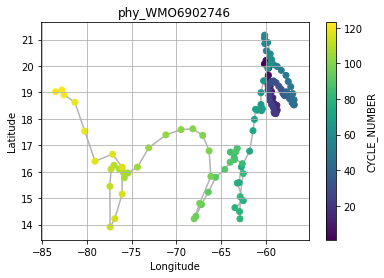

In [10]:
this = argo.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], '-', color=[0.7]*3, zorder=0)
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(argo.attrs['Download_constraints'])
plt.show()

## QC flags for appropriate variables

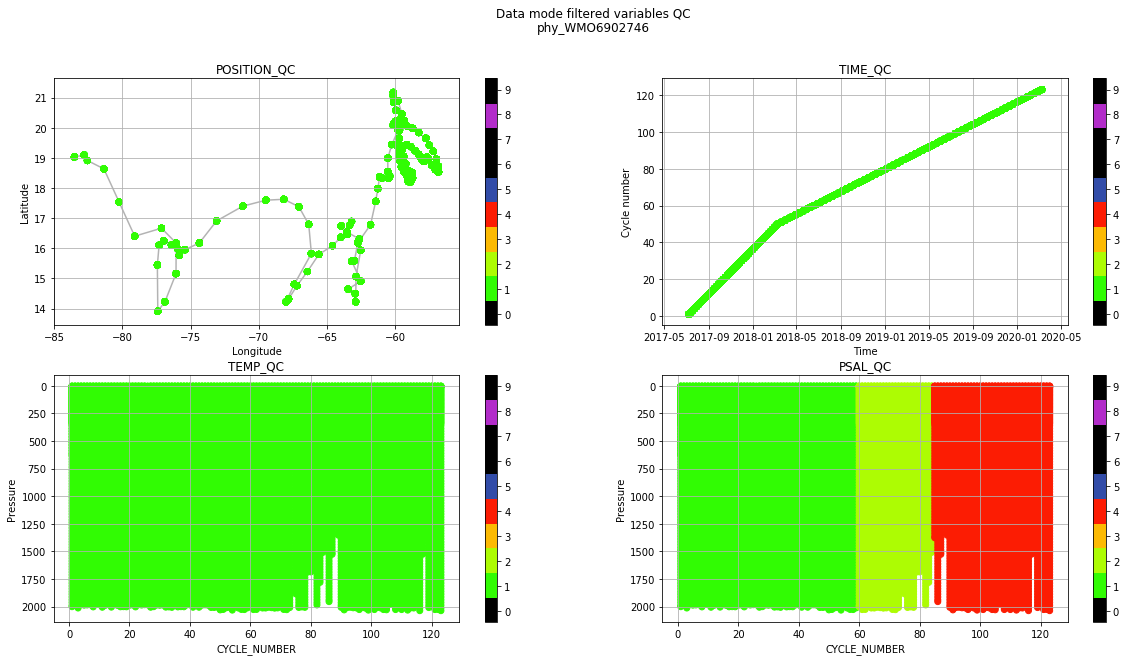

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(argo['longitude'], argo['latitude'], '-', color=[0.7]*3, zorder=0)
sc = ax[ix].scatter(argo['longitude'], argo['latitude'], c=argo['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=argo['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("Data mode filtered variables QC\n%s" % argo.attrs['Download_constraints']);

## DATA MODE

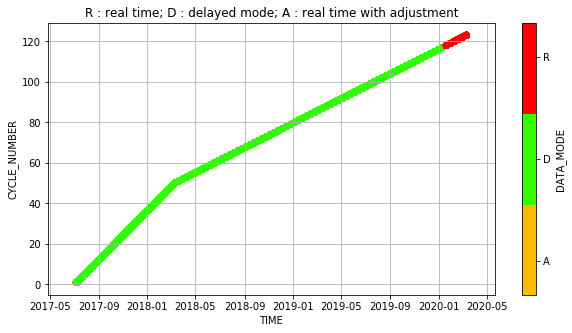

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(argo['time'].values, argo['CYCLE_NUMBER'], c=le.transform(argo['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_ylabel('CYCLE_NUMBER')
ax[0].set_xlabel('TIME')
ax[0].grid()
ax[0].set_title(argo['DATA_MODE'].attrs['convention']);

## Hovmoller

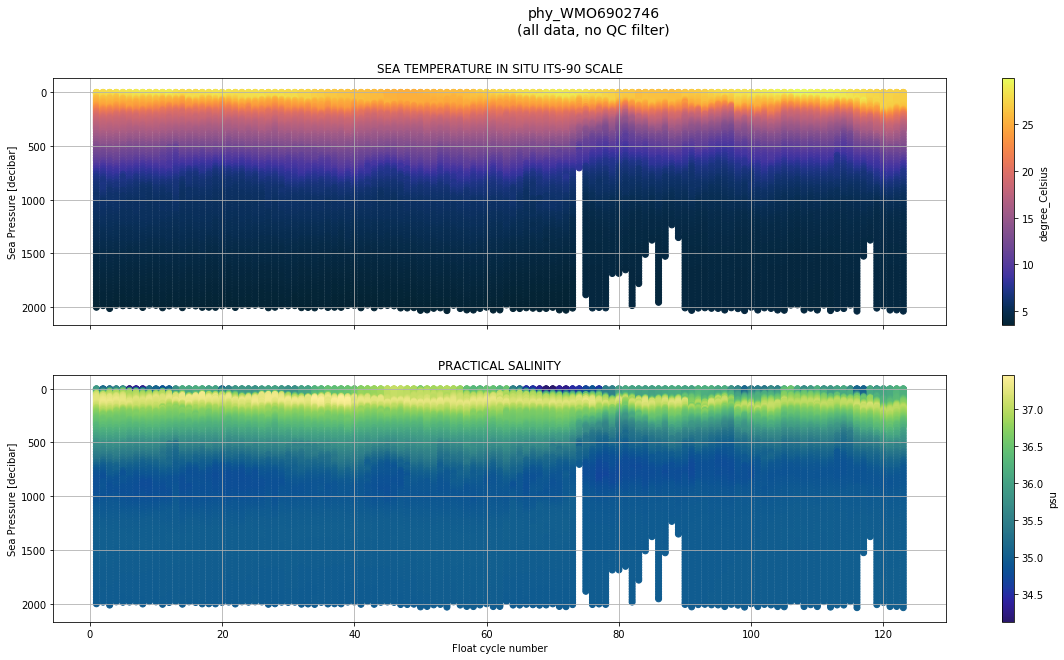

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].grid()
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

fig.suptitle("%s\n(all data, no QC filter)" % argo.attrs['Download_constraints'], fontsize=14);

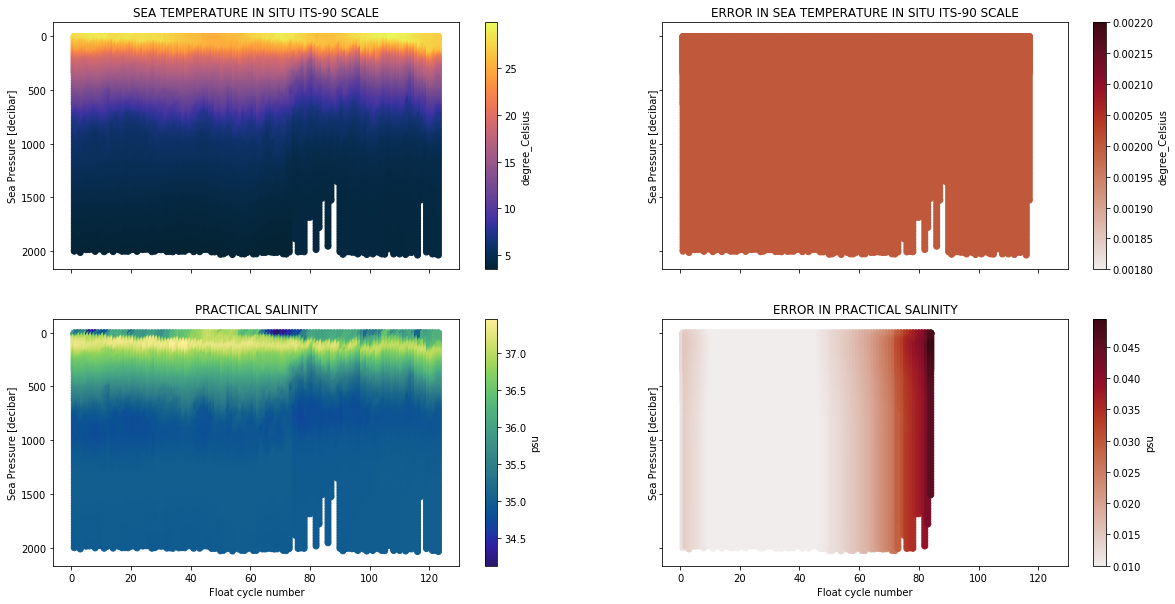

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo['CYCLE_NUMBER'], argo['PRES'], c=argo['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['PSAL_ERROR'].attrs['long_name']);

## Super-imposed profiles

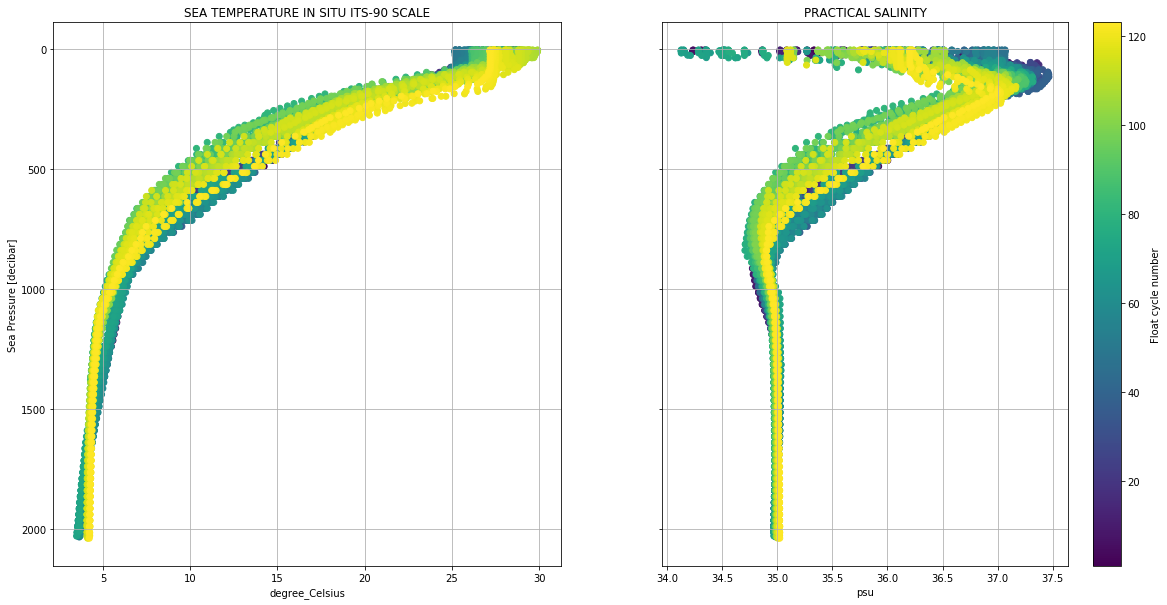

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo['TEMP'], argo['PRES'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo['PRES'].attrs['long_name'], argo['PRES'].attrs['units']))
ax[ix].set_title(argo['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo['PSAL'], argo['PRES'], c=argo['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo['PSAL'].attrs['units'])
ax[ix].set_title(argo['PSAL'].attrs['long_name']);


## T/S diagram

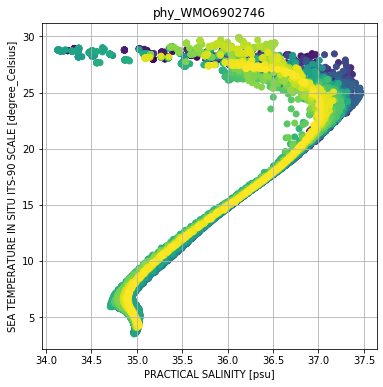

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(argo['PSAL'], argo['TEMP'], c=argo['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (argo['PSAL'].attrs['long_name'], argo['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (argo['TEMP'].attrs['long_name'], argo['TEMP'].attrs['units']))
plt.title(argo.attrs['Download_constraints']);

# Filter data according to QC flags

In [17]:
argo_ok = float_fetcher.fetcher.filter_qc(argo)

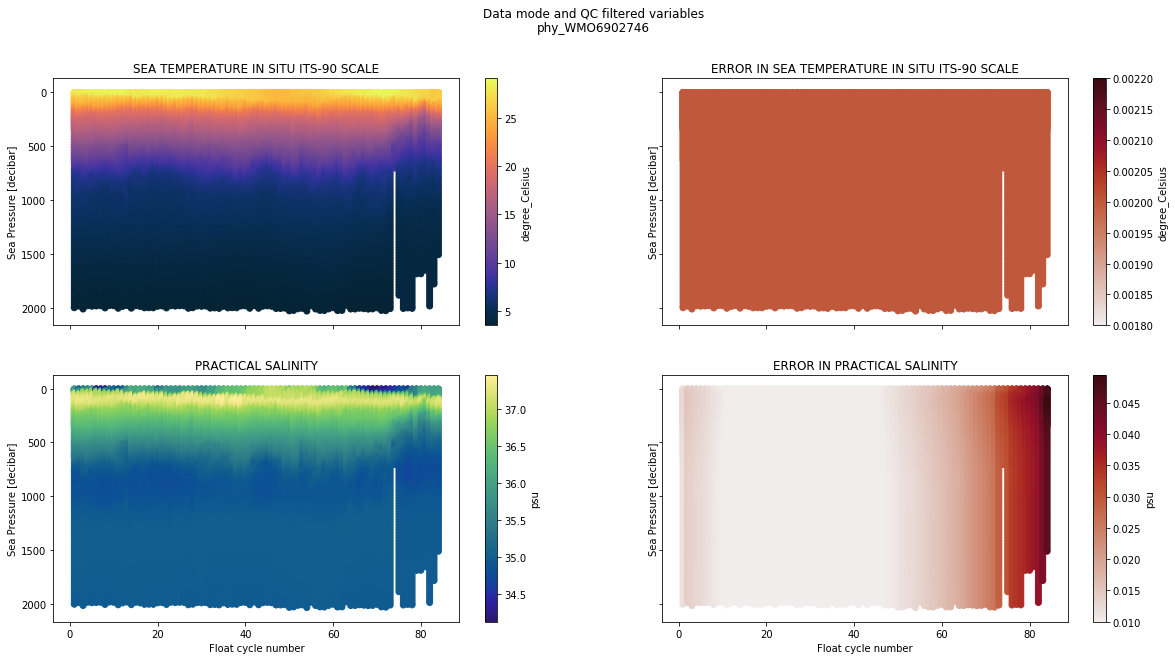

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(argo_ok['CYCLE_NUMBER'], argo_ok['PRES'], c=argo_ok['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=argo_ok['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['PSAL_ERROR'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);

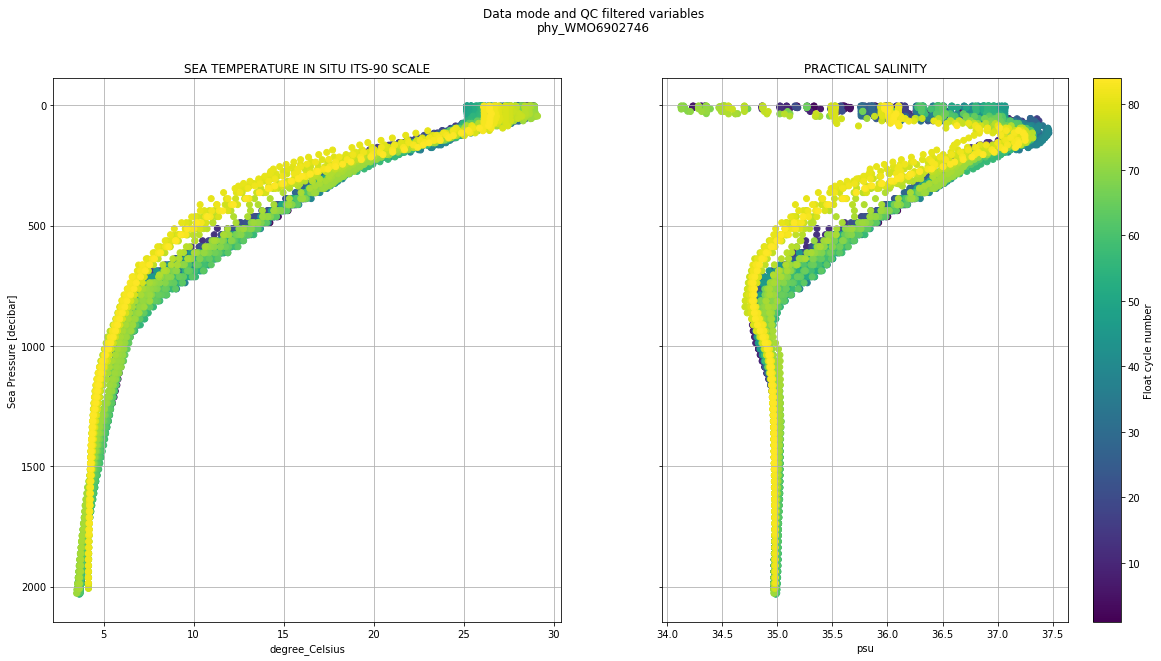

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(argo_ok['TEMP'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(argo_ok['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (argo_ok['PRES'].attrs['long_name'], argo_ok['PRES'].attrs['units']))
ax[ix].set_title(argo_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(argo_ok['PSAL'], argo_ok['PRES'], c=argo_ok['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=argo_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(argo_ok['PSAL'].attrs['units'])
ax[ix].set_title(argo_ok['PSAL'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % argo.attrs['Download_constraints']);

***
This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>